# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/viktor/mlfs-book-a-version
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 23, 18, 44, 379816)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()


2025-11-18 23:18:51,798 INFO: Initializing external client
2025-11-18 23:18:51,800 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 23:18:52,457 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 23:18:53,057 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1296538


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

"""retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)"""
#Replaced for C-part!
"""retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_lag",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()"""

'retrieved_model = mr.get_model(\n    name="air_quality_xgboost_model_lag",\n    version=1,\n)\n\nfv = retrieved_model.get_feature_view()\n\n# Download the saved model artifacts to a local directory\nsaved_model_dir = retrieved_model.download()'

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
"""retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model"""

'retrieved_xgboost_model = XGBRegressor()\n\nretrieved_xgboost_model.load_model(saved_model_dir + "/model.json")\n\n# Displaying the retrieved XGBoost regressor model\nretrieved_xgboost_model'

In [7]:
def forecast_recursive(model, row_today, rows_to_predict, feature_cols, max_horizon, use_lags):
    rows = rows_to_predict.sort_values("date").reset_index(drop=True).copy()
    predictions = []
    
    if use_lags: #establish a starting point (today!): 
        lag_1 = row_today['pm25']
        lag_2 = row_today['pm25_lag1']
        lag_3 = row_today['pm25_lag2']

    max_horizon = min(max_horizon, len(rows)) #just in case i send in something weird later!
    
    for h in range(max_horizon): #from tomorrow onwards: 
        idx = rows.index[h]
        
        if use_lags: #overwrite possible real values (which is illegal to use here) with predicted values!
            rows.at[idx, "pm25_lag1"] = lag_1
            rows.at[idx, "pm25_lag2"] = lag_2
            rows.at[idx, "pm25_lag3"] = lag_3
            
        X_row = rows.loc[idx, feature_cols].values.reshape(1, -1)
        
        y_pred = float(model.predict(X_row)[0])

        predictions.append(y_pred)
        if use_lags:
            #push all lags back because we move forward one day:
            lag_3 = lag_2 
            lag_2 = lag_1
            lag_1 = y_pred

        
    return predictions, rows

"""def forecast_recursive(model, row_today, rows_to_predict, feature_cols, max_horizon, use_lags):
    predictions = []
    
    if use_lags: #establish a starting point (today!): 
        lag_1 = row_today['pm25']
        lag_2 = row_today['pm25_lag1']
        lag_3 = row_today['pm25_lag2']
        
    for h in range(max_horizon): #from tomorrow onwards: 
        row_to_predict = rows_to_predict.iloc[h].copy()
        
        if use_lags: #overwrite possible real values (which is illegal to use here) with predicted values!
            row_to_predict['pm25_lag1'] = lag_1
            row_to_predict['pm25_lag2'] = lag_2
            row_to_predict['pm25_lag3'] = lag_3
            
        X_row = row_to_predict[feature_cols].values.reshape(1, -1)
        y_pred = float(model.predict(X_row)[0])

        predictions.append(y_pred)
        if use_lags:
            #push all lags back because we move forward one day:
            lag_3 = lag_2 
            lag_2 = lag_1
            lag_1 = y_pred

        
    return predictions"""


"def forecast_recursive(model, row_today, rows_to_predict, feature_cols, max_horizon, use_lags):\n    predictions = []\n    \n    if use_lags: #establish a starting point (today!): \n        lag_1 = row_today['pm25']\n        lag_2 = row_today['pm25_lag1']\n        lag_3 = row_today['pm25_lag2']\n        \n    for h in range(max_horizon): #from tomorrow onwards: \n        row_to_predict = rows_to_predict.iloc[h].copy()\n        \n        if use_lags: #overwrite possible real values (which is illegal to use here) with predicted values!\n            row_to_predict['pm25_lag1'] = lag_1\n            row_to_predict['pm25_lag2'] = lag_2\n            row_to_predict['pm25_lag3'] = lag_3\n            \n        X_row = row_to_predict[feature_cols].values.reshape(1, -1)\n        y_pred = float(model.predict(X_row)[0])\n\n        predictions.append(y_pred)\n        if use_lags:\n            #push all lags back because we move forward one day:\n            lag_3 = lag_2 \n            lag_2 = lag_1\

In [8]:
#Get the feature group for the lags:

#first just get feature_cols (which features the model expects):
"""X_sample = fv.get_batch_data()
if "pm25" in X_sample.columns:
    X_sample = X_sample.drop(columns=['pm25'])
X_sample = X_sample.drop(columns=['date'])  #model does not expect a date.
feature_cols = list(X_sample.columns)

air_quality_fg_v2 = fs.get_feature_group(
    name="air_quality",
    version=2,
)
#We are just interested in today's values (or at least, the latest value if today data does not exist!):

history = air_quality_fg_v2.read()
sensor_history = history.query("country == @country and city == @city and street == @street").copy()

sensor_history["date"] = pd.to_datetime(sensor_history["date"])  #ensure correct format

sensor_history = sensor_history.sort_values("date")

row_today = sensor_history.iloc[-1]
row_today"""

'X_sample = fv.get_batch_data()\nif "pm25" in X_sample.columns:\n    X_sample = X_sample.drop(columns=[\'pm25\'])\nX_sample = X_sample.drop(columns=[\'date\'])  #model does not expect a date.\nfeature_cols = list(X_sample.columns)\n\nair_quality_fg_v2 = fs.get_feature_group(\n    name="air_quality",\n    version=2,\n)\n#We are just interested in today\'s values (or at least, the latest value if today data does not exist!):\n\nhistory = air_quality_fg_v2.read()\nsensor_history = history.query("country == @country and city == @city and street == @street").copy()\n\nsensor_history["date"] = pd.to_datetime(sensor_history["date"])  #ensure correct format\n\nsensor_history = sensor_history.sort_values("date")\n\nrow_today = sensor_history.iloc[-1]\nrow_today'

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [9]:
"""weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()

#Additions C-part:
batch_data = batch_data.sort_values("date").reset_index(drop=True)

#C-part, want to add empty 
import numpy as np

batch_data = batch_data.copy()   #probably not nessecary, but for paranoia
batch_data["pm25_lag1"] = np.nan
batch_data["pm25_lag2"] = np.nan
batch_data["pm25_lag3"] = np.nan

batch_data"""

'weather_fg = fs.get_feature_group(\n    name=\'weather\',\n    version=1,\n)\nbatch_data = weather_fg.filter(weather_fg.date >= today).read()\n\n#Additions C-part:\nbatch_data = batch_data.sort_values("date").reset_index(drop=True)\n\n#C-part, want to add empty \nimport numpy as np\n\nbatch_data = batch_data.copy()   #probably not nessecary, but for paranoia\nbatch_data["pm25_lag1"] = np.nan\nbatch_data["pm25_lag2"] = np.nan\nbatch_data["pm25_lag3"] = np.nan\n\nbatch_data'

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [10]:
"""batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data"""

"""
use_lags = True
predicitons, batch_data = forecast_recursive(retrieved_xgboost_model, row_today, batch_data, feature_cols, len(batch_data), use_lags)

batch_data["predicted_pm25"] = predicitons
batch_data"""

'\nuse_lags = True\npredicitons, batch_data = forecast_recursive(retrieved_xgboost_model, row_today, batch_data, feature_cols, len(batch_data), use_lags)\n\nbatch_data["predicted_pm25"] = predicitons\nbatch_data'

In [11]:
#batch_data.info()

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [12]:
"""batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data"""

"batch_data['street'] = street\nbatch_data['city'] = city\nbatch_data['country'] = country\n# Fill in the number of days before the date on which you made the forecast (base_date)\nbatch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)\nbatch_data = batch_data.sort_values(by=['date'])\nbatch_data"

In [13]:
#batch_data.info()

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

In [14]:

"""pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()"""

'pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"\nplt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)\n\nplt.show()'

In [15]:
# Get or create feature group               MAY HAVE TO CHANGE THIS TO VERSION 2. 
"""monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=2,   #Changed from version 1 to 2 for C-part
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)"""

'monitor_fg = fs.get_or_create_feature_group(\n    name=\'aq_predictions\',\n    description=\'Air Quality prediction monitoring\',\n    version=2,   #Changed from version 1 to 2 for C-part\n    primary_key=[\'city\',\'street\',\'date\',\'days_before_forecast_day\'],\n    event_time="date"\n)'

In [16]:
#monitor_fg.insert(batch_data, wait=True)

In [17]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
"""monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df"""

'monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()\nmonitoring_df'

In [18]:
"""air_quality_fg = fs.get_feature_group(name='air_quality', version=2)   #changed from version 1 to version 2 for C-part
air_quality_df = air_quality_fg.read()
air_quality_df = air_quality_df.sort_values("date").reset_index(drop=True)
air_quality_df"""

'air_quality_fg = fs.get_feature_group(name=\'air_quality\', version=2)   #changed from version 1 to version 2 for C-part\nair_quality_df = air_quality_fg.read()\nair_quality_df = air_quality_df.sort_values("date").reset_index(drop=True)\nair_quality_df'

In [19]:
def backfill_predictions_for_monitoring_lag_model(weather_fg, air_quality_df_v2, monitor_fg, model, feature_cols, country, city, street):
    features_df = weather_fg.read()
    features_df["date"] = pd.to_datetime(features_df["date"])
    features_df = features_df.sort_values(by=['date'], ascending=True)
    
    sensor_history = air_quality_df_v2.query("country == @country and city == @city and street == @street").copy()
    sensor_history["date"] = pd.to_datetime(sensor_history["date"])

    sensor_history = sensor_history[["date", "pm25", "pm25_lag1", "pm25_lag2", "pm25_lag3"]] 
    features_df = pd.merge(
        features_df,
        sensor_history,
        on="date",
        how="inner",   #only keep dataes both have (but it shouldnt be a problem)
    )

    features_df = features_df.sort_values("date")
    features_df = features_df.tail(10)

    features_df = features_df.dropna(subset=["pm25_lag1", "pm25_lag2", "pm25_lag3"])  #should not be any, but just in case
    
    features_df["predicted_pm25"] = model.predict(features_df[feature_cols])
    for col in ["pm25_lag1", "pm25_lag2", "pm25_lag3", "predicted_pm25"]:
        features_df[col] = features_df[col].astype("float64")
        
    features_df['days_before_forecast_day'] = 1
    features_df['city'] = city
    features_df['country'] = country
    features_df['street'] = street
    
    hindcast_df = features_df.copy()
    features_df = features_df.drop('pm25', axis=1)
    monitor_fg.insert(features_df, write_options={"wait_for_job": True})
    
    return hindcast_df

In [20]:
"""outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    #hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
    hindcast_df = backfill_predictions_for_monitoring_lag_model(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model, feature_cols, country, city, street)
hindcast_df"""

'outcome_df = air_quality_df[[\'date\', \'pm25\']]\npreds_df =  monitoring_df[[\'date\', \'predicted_pm25\']]\n\nhindcast_df = pd.merge(preds_df, outcome_df, on="date")\nhindcast_df = hindcast_df.sort_values(by=[\'date\'])\n\n# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data\nif len(hindcast_df) == 0:\n    #hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)\n    hindcast_df = backfill_predictions_for_monitoring_lag_model(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model, feature_cols, country, city, street)\nhindcast_df'

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

In [21]:
"""hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()"""

'hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"\nplt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)\nplt.show()'

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [22]:
"""dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")"""

'dataset_api = project.get_dataset_api()\nstr_today = today.strftime("%Y-%m-%d")\nif dataset_api.exists("Resources/airquality") == False:\n    dataset_api.mkdir("Resources/airquality")\ndataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)\ndataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)\n\nproj_url = project.get_url()\nprint(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")'

---

In [23]:
#A- PART
AQICN_API_KEY = secrets.get_secret("AQICN_API_KEY").value
mr = project.get_model_registry()
import numpy as np

def inference(country, city, street, aqicn_url):


    street_safe = street.replace(" ", "_").lower()
    model_name = f"air_quality_xgboost_model_lag{street_safe}"
    
    retrieved_model = mr.get_model(
        name=model_name,
        version=1,
    )
    
    fv = retrieved_model.get_feature_view()
    
    # Download the saved model artifacts to a local directory
    saved_model_dir = retrieved_model.download()

    # Loading the XGBoost regressor model and label encoder from the saved model directory
    # retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
    retrieved_xgboost_model = XGBRegressor()
    
    retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")
    
    # Displaying the retrieved XGBoost regressor model
    retrieved_xgboost_model

    #Get the feature group for the lags:

    #first just get feature_cols (which features the model expects):
    X_sample = fv.get_batch_data()
    if "pm25" in X_sample.columns:
        X_sample = X_sample.drop(columns=['pm25'])
    X_sample = X_sample.drop(columns=['date'])  #model does not expect a date.
    feature_cols = list(X_sample.columns)
    
    air_quality_fg_v2 = fs.get_feature_group(
        name="air_quality",
        version=3,
    )
    #We are just interested in today's values (or at least, the latest value if today data does not exist!):
    
    history = air_quality_fg_v2.read()
    sensor_history = history.query("country == @country and city == @city and street == @street").copy()
    
    sensor_history["date"] = pd.to_datetime(sensor_history["date"])  #ensure correct format
    
    sensor_history = sensor_history.sort_values("date")
    
    row_today = sensor_history.iloc[-1]
    print(row_today)

    weather_fg = fs.get_feature_group(
        name='weather',
        version=3,
    )
    batch_data = weather_fg.filter(weather_fg.date >= today).read()
    
    #Additions C-part:
    batch_data = batch_data.sort_values("date").reset_index(drop=True)
    
    #C-part, want to add empty 
    batch_data = batch_data.copy()   #probably not nessecary, but for paranoia
    batch_data["pm25_lag1"] = np.nan
    batch_data["pm25_lag2"] = np.nan
    batch_data["pm25_lag3"] = np.nan
    print(batch_data)

    use_lags = True
    predicitons, batch_data = forecast_recursive(retrieved_xgboost_model, row_today, batch_data, feature_cols, len(batch_data), use_lags)
    
    batch_data["predicted_pm25"] = predicitons
    print(batch_data)
    print(batch_data.info())

    batch_data['street'] = street
    batch_data['city'] = city
    batch_data['country'] = country
    # Fill in the number of days before the date on which you made the forecast (base_date)
    batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
    batch_data = batch_data.sort_values(by=['date'])
    print(batch_data)
    print(batch_data.info())
    
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast{street_safe}.png"
    plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)
    plt.show()
    
    # Get or create feature group               MAY HAVE TO CHANGE THIS TO VERSION 2. 
    monitor_fg = fs.get_or_create_feature_group(
        name='aq_predictions',
        description='Air Quality prediction monitoring',
        version=3,   #3 for A
        primary_key=['city','street','date','days_before_forecast_day'],
        event_time="date"
    )
    monitor_fg.insert(batch_data, wait=True)

    #monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
    monitoring_df = monitor_fg.filter((monitor_fg.street == street) & (monitor_fg.days_before_forecast_day == 1)).read()
    print(monitoring_df)

    air_quality_fg = fs.get_feature_group(name='air_quality', version=3)   #changed from version 1 to version 2 for C-part
    air_quality_df = air_quality_fg.filter((air_quality_fg.street == street)).read()
    
    air_quality_df = air_quality_df.sort_values("date").reset_index(drop=True)
    print(air_quality_df)

    outcome_df = air_quality_df[['date', 'pm25']]
    preds_df =  monitoring_df[['date', 'predicted_pm25']]
    
    hindcast_df = pd.merge(preds_df, outcome_df, on="date")
    hindcast_df = hindcast_df.sort_values(by=['date'])
    
    # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
    if len(hindcast_df) == 0:
        #hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
        hindcast_df = backfill_predictions_for_monitoring_lag_model(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model, feature_cols, country, city, street)
    print(hindcast_df)

    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day{street_safe}.png"
    plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
    plt.show()

    dataset_api = project.get_dataset_api()
    
    str_today = today.strftime("%Y-%m-%d")
    if dataset_api.exists("Resources/airquality") == False:
        dataset_api.mkdir("Resources/airquality")
    dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
    dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
    
    proj_url = project.get_url()
    print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")


In [24]:
#load sensor info. 
config_path=f"{root_dir}/config/sensors.json"


with open(config_path, "r") as f:
    SENSORS = json.load(f)

print("Loaded sensors:", len(SENSORS))
SENSORS

Loaded sensors: 6


[{'country': 'uk',
  'city': 'dundee',
  'street': 'lochee road',
  'aqicn_url': 'https://api.waqi.info/feed/@5971/',
  'csv_file': 'lochee road'},
 {'country': 'uk',
  'city': 'dundee',
  'street': 'whitehall street',
  'aqicn_url': 'https://api.waqi.info/feed/@9579/',
  'csv_file': 'whitehall street'},
 {'country': 'uk',
  'city': 'dundee',
  'street': 'meadowside',
  'aqicn_url': 'https://api.waqi.info/feed/@5973/',
  'csv_file': 'meadowside'},
 {'country': 'uk',
  'city': 'dundee',
  'street': 'seagate',
  'aqicn_url': 'https://api.waqi.info/feed/@5974/',
  'csv_file': 'seagate'},
 {'country': 'uk',
  'city': 'dundee',
  'street': 'mains loan',
  'aqicn_url': 'https://api.waqi.info/feed/@5972/',
  'csv_file': 'mains loan'},
 {'country': 'uk',
  'city': 'dundee',
  'street': 'broughty ferry road',
  'aqicn_url': 'https://api.waqi.info/feed/@5970/',
  'csv_file': 'broughty ferry road'}]

{"country": "uk", "city": "dundee", "street": "lochee road", "aqicn_url": "https://api.waqi.info/feed/@5971/", "latitude": 56.46, "longitude": -2.97}
2025-11-18 23:19:19,181 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/489062 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/118726 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25964 elapsed<00:00 remaining<?

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.77s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.41s) 
date                 2025-11-18 00:00:00+00:00
pm25                                      10.0
country                                     uk
city                                    dundee
street                             lochee road
url          https://api.waqi.info/feed/@5971/
pm25_lag1                                 29.0
pm25_lag2                                 18.0
pm25_lag3                                 21.0
Name: 567, dtype: object
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.81s) 
                       date  temperature_2m_mean  precipitation_sum  \
0 2025-11-20 00:00:00+00:00                 4.20                0.0   
1 2025-11-21 00:00:00+00:00                 1.35                0.0   
2 2025-11-22 00:00:00+00:00                 7.05                0.0   
3 2025-11-

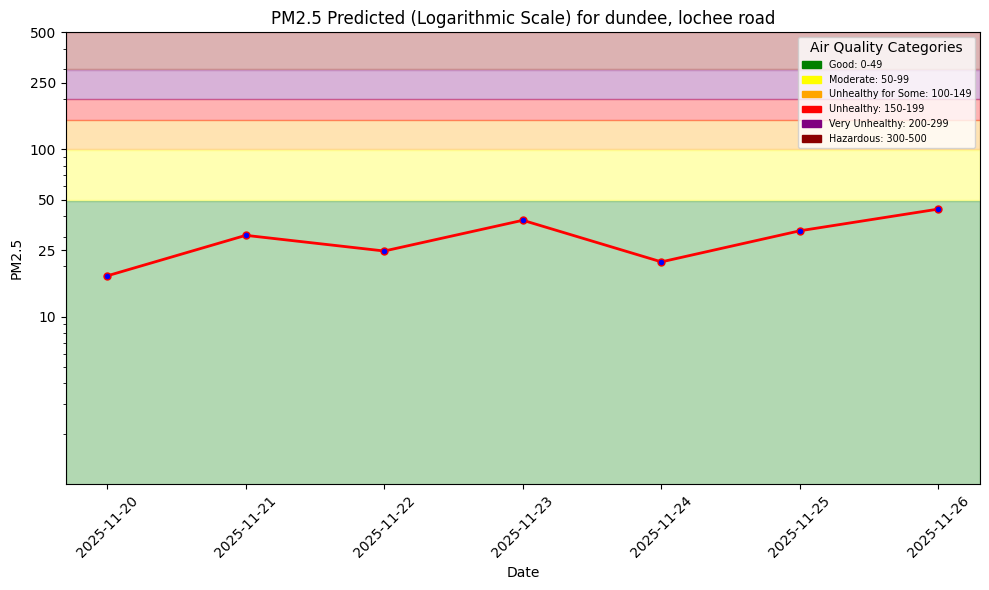

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1296538/fs/1284171/fg/1722064


Uploading Dataframe: 100.00% |██████████████████████████████████| Rows 7/7 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296538/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-18 23:20:14,343 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 23:20:17,543 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 23:21:52,586 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 23:21:52,734 INFO: Waiting for log aggregation to finish.
2025-11-18 23:22:04,649 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.09s) 
                       date  temperature_2m_mean  precipitation_sum  \
0 2025-11-20 00:00:00+00:00                  4.2                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant    city  pm25_lag

Uploading Dataframe: 100.00% |████████████████████████████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296538/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-18 23:22:26,155 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 23:22:29,329 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 23:23:54,786 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 23:23:54,928 INFO: Waiting for log aggregation to finish.
2025-11-18 23:24:06,788 INFO: Execution finished successfully.
                          date  temperature_2m_mean  precipitation_sum  \
2722 2025-11-09 00:00:00+00:00             8.686749           6.500000   
2723 2025-11-10 00:00:00+00:00             9.188833          11.400001   
2724 2025-11-11 00:00:00+00:00             8.113833          14.099998   
2725

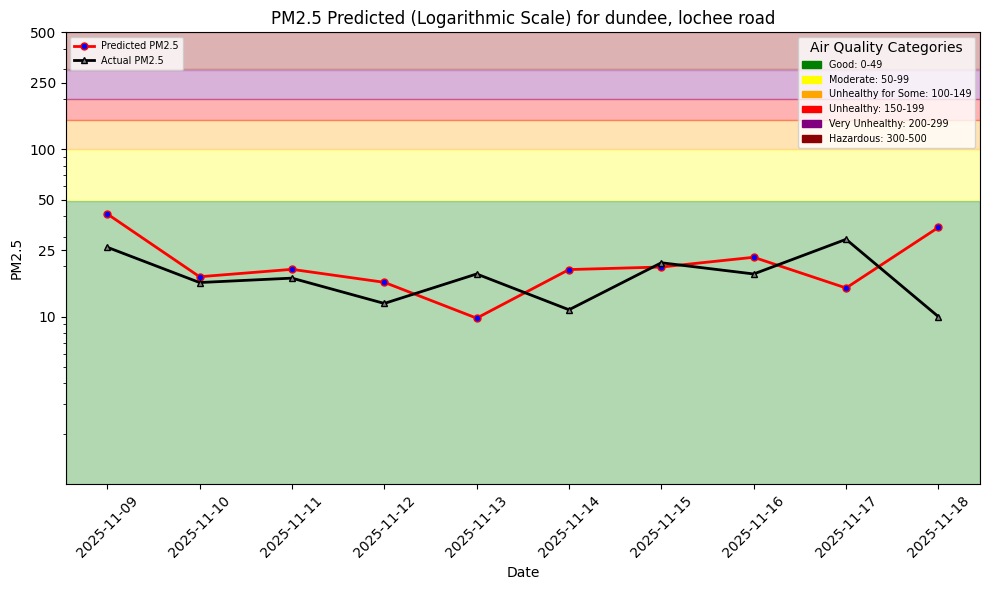

Uploading /home/viktor/mlfs-book-a-version/docs/air-quality/assets/img/pm25_forecastlochee_road.png: 0.000%|  …

Uploading /home/viktor/mlfs-book-a-version/docs/air-quality/assets/img/pm25_hindcast_1daylochee_road.png: 0.00…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1296538/settings/fb/path/Resources/airquality
{"country": "uk", "city": "dundee", "street": "whitehall street", "aqicn_url": "https://api.waqi.info/feed/@9579/", "latitude": 56.46, "longitude": -2.97}
2025-11-18 23:24:15,832 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/509665 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/117855 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25966 elapsed<00:00 remaining<?

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.53s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.27s) 
date                 2025-11-18 00:00:00+00:00
pm25                                      14.0
country                                     uk
city                                    dundee
street                        whitehall street
url          https://api.waqi.info/feed/@9579/
pm25_lag1                                 17.0
pm25_lag2                                 17.0
pm25_lag3                                 24.0
Name: 3459, dtype: object
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 
                       date  temperature_2m_mean  precipitation_sum  \
0 2025-11-20 00:00:00+00:00                 4.20                0.0   
1 2025-11-21 00:00:00+00:00                 1.35                0.0   
2 2025-11-22 00:00:00+00:00                 7.05                0.0   
3 2025-11

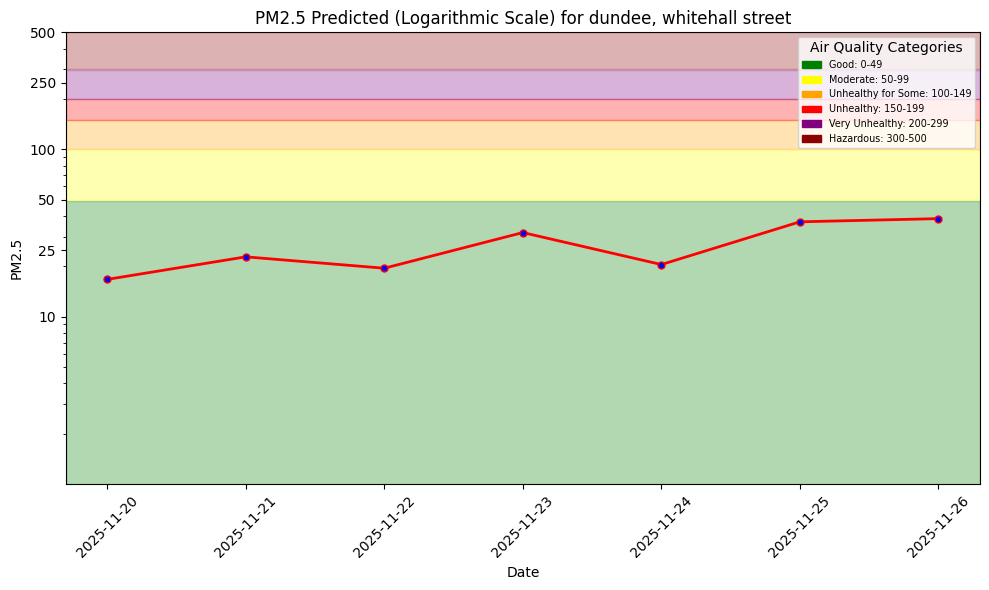

Uploading Dataframe: 100.00% |██████████████████████████████████| Rows 7/7 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296538/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-18 23:25:13,600 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 23:25:45,170 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 23:27:39,168 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 23:27:39,302 INFO: Waiting for log aggregation to finish.
2025-11-18 23:28:01,025 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.26s) 
                       date  temperature_2m_mean  precipitation_sum  \
0 2025-11-20 00:00:00+00:00                  4.2                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant    city  pm25_lag1  

Uploading Dataframe: 100.00% |████████████████████████████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296538/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-18 23:28:21,919 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 23:28:25,116 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 23:30:38,422 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 23:30:38,622 INFO: Waiting for log aggregation to finish.
2025-11-18 23:30:53,900 INFO: Execution finished successfully.
                          date  temperature_2m_mean  precipitation_sum  \
2687 2025-11-09 00:00:00+00:00             8.686749           6.500000   
2688 2025-11-10 00:00:00+00:00             9.188833          11.400001   
2689 2025-11-11 00:00:00+00:00             8.113833          14.099998   
2690

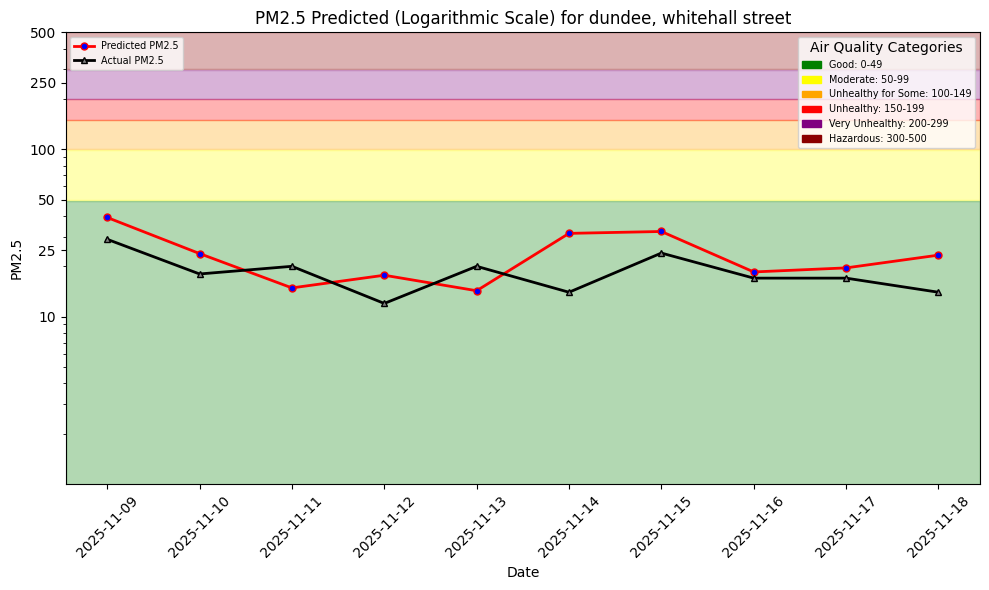

Uploading /home/viktor/mlfs-book-a-version/docs/air-quality/assets/img/pm25_forecastwhitehall_street.png: 0.00…

Uploading /home/viktor/mlfs-book-a-version/docs/air-quality/assets/img/pm25_hindcast_1daywhitehall_street.png:…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1296538/settings/fb/path/Resources/airquality
{"country": "uk", "city": "dundee", "street": "meadowside", "aqicn_url": "https://api.waqi.info/feed/@5973/", "latitude": 56.46, "longitude": -2.97}
2025-11-18 23:31:03,160 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/496986 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/119454 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26515 elapsed<00:00 remaining<?

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.86s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.55s) 
date                 2025-11-18 00:00:00+00:00
pm25                                      12.0
country                                     uk
city                                    dundee
street                              meadowside
url          https://api.waqi.info/feed/@5973/
pm25_lag1                                 21.0
pm25_lag2                                 16.0
pm25_lag3                                 22.0
Name: 7919, dtype: object
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.75s) 
                       date  temperature_2m_mean  precipitation_sum  \
0 2025-11-20 00:00:00+00:00                 4.20                0.0   
1 2025-11-21 00:00:00+00:00                 1.35                0.0   
2 2025-11-22 00:00:00+00:00                 7.05                0.0   
3 2025-11

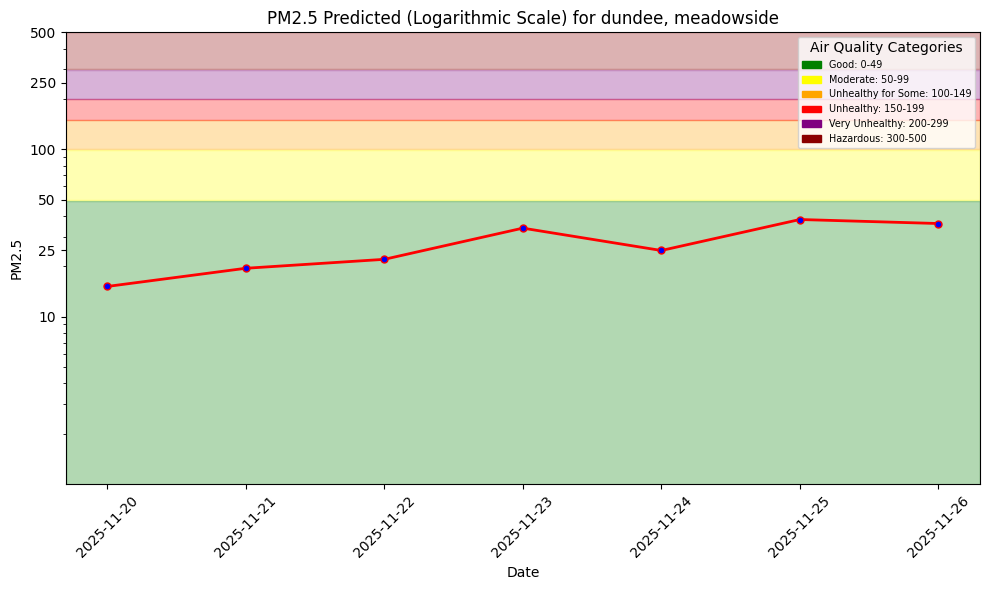

Uploading Dataframe: 100.00% |██████████████████████████████████| Rows 7/7 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296538/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-18 23:31:31,791 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 23:31:34,979 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 23:33:26,225 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 23:33:26,385 INFO: Waiting for log aggregation to finish.
2025-11-18 23:33:48,268 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.04s) 
                       date  temperature_2m_mean  precipitation_sum  \
0 2025-11-20 00:00:00+00:00                  4.2                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant    city  pm25_lag

Uploading Dataframe: 100.00% |████████████████████████████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296538/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-18 23:34:10,312 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 23:34:13,484 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 23:35:39,520 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 23:35:39,687 INFO: Waiting for log aggregation to finish.
2025-11-18 23:35:48,268 INFO: Execution finished successfully.
                          date  temperature_2m_mean  precipitation_sum  \
2633 2025-11-09 00:00:00+00:00             8.686749           6.500000   
2634 2025-11-10 00:00:00+00:00             9.188833          11.400001   
2635 2025-11-11 00:00:00+00:00             8.113833          14.099998   
2636

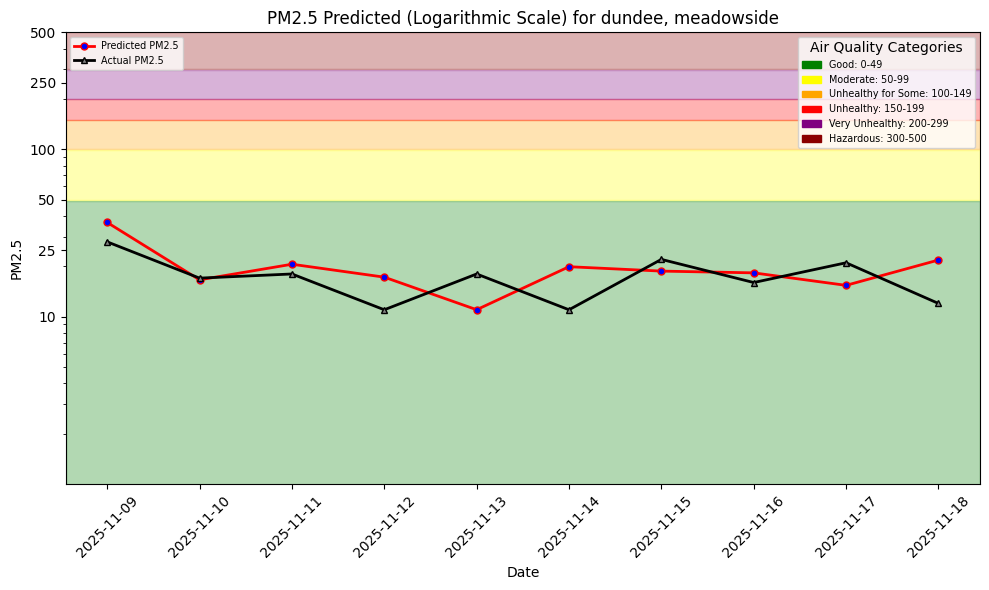

Uploading /home/viktor/mlfs-book-a-version/docs/air-quality/assets/img/pm25_forecastmeadowside.png: 0.000%|   …

Uploading /home/viktor/mlfs-book-a-version/docs/air-quality/assets/img/pm25_hindcast_1daymeadowside.png: 0.000…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1296538/settings/fb/path/Resources/airquality
{"country": "uk", "city": "dundee", "street": "seagate", "aqicn_url": "https://api.waqi.info/feed/@5974/", "latitude": 56.46, "longitude": -2.97}
2025-11-18 23:35:57,434 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/515020 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112943 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25644 elapsed<00:00 remaining<?

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.81s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.43s) 
date                 2025-11-18 00:00:00+00:00
pm25                                      11.0
country                                     uk
city                                    dundee
street                                 seagate
url          https://api.waqi.info/feed/@5974/
pm25_lag1                                 20.0
pm25_lag2                                 18.0
pm25_lag3                                 20.0
Name: 9330, dtype: object
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.83s) 
                       date  temperature_2m_mean  precipitation_sum  \
0 2025-11-20 00:00:00+00:00                 4.20                0.0   
1 2025-11-21 00:00:00+00:00                 1.35                0.0   
2 2025-11-22 00:00:00+00:00                 7.05                0.0   
3 2025-11

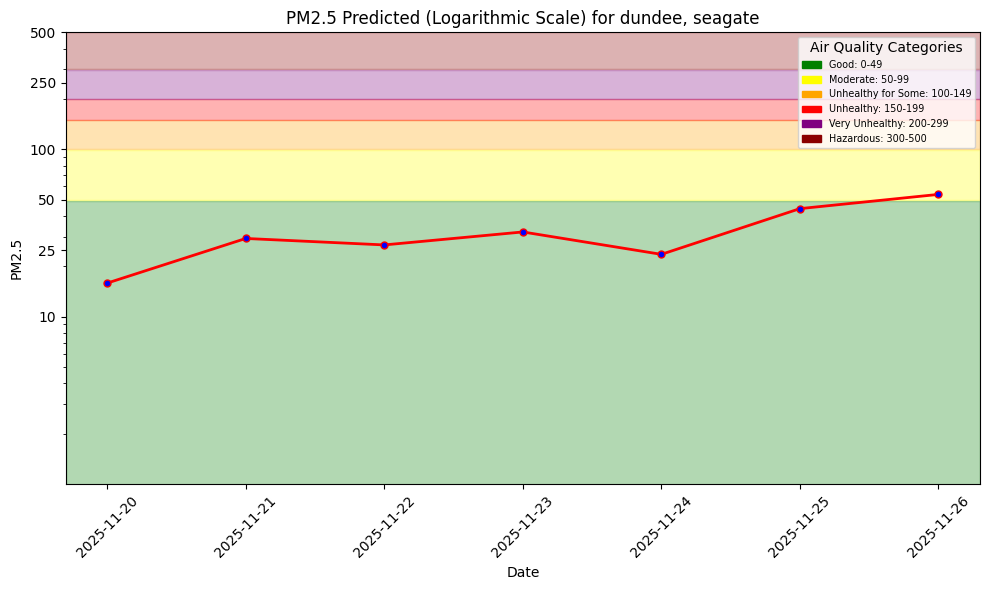

Uploading Dataframe: 100.00% |██████████████████████████████████| Rows 7/7 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296538/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-18 23:36:26,165 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 23:36:29,353 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 23:37:55,193 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 23:37:55,361 INFO: Waiting for log aggregation to finish.
2025-11-18 23:38:13,965 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.22s) 
                       date  temperature_2m_mean  precipitation_sum  \
0 2025-11-20 00:00:00+00:00                  4.2                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant    city  pm25_lag

Uploading Dataframe: 100.00% |████████████████████████████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296538/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-18 23:38:34,700 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 23:38:37,856 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 23:40:00,655 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 23:40:00,798 INFO: Waiting for log aggregation to finish.
2025-11-18 23:40:09,377 INFO: Execution finished successfully.
                          date  temperature_2m_mean  precipitation_sum  \
2689 2025-11-09 00:00:00+00:00             8.686749           6.500000   
2690 2025-11-10 00:00:00+00:00             9.188833          11.400001   
2691 2025-11-11 00:00:00+00:00             8.113833          14.099998   
2692

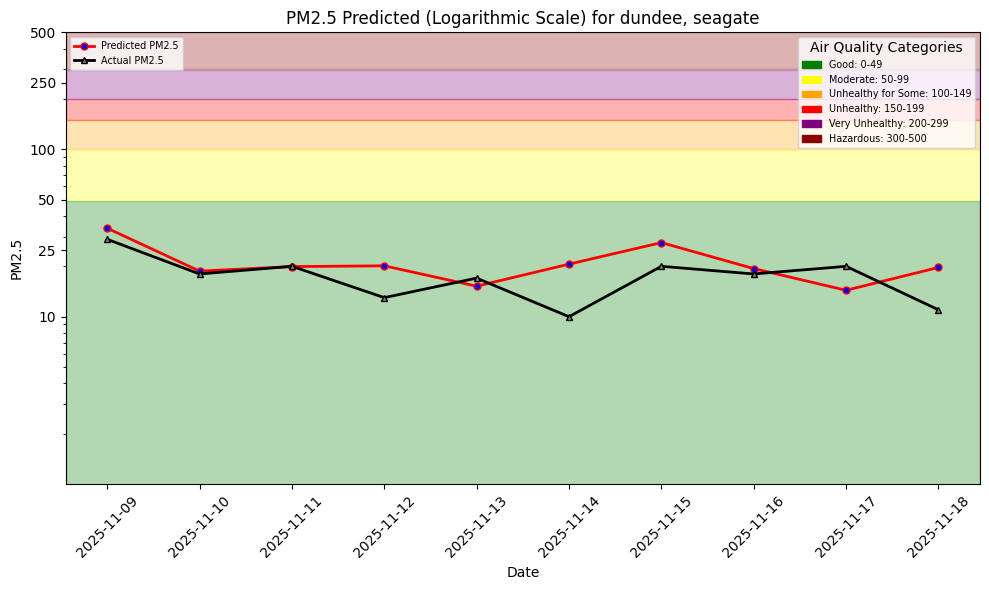

Uploading /home/viktor/mlfs-book-a-version/docs/air-quality/assets/img/pm25_forecastseagate.png: 0.000%|      …

Uploading /home/viktor/mlfs-book-a-version/docs/air-quality/assets/img/pm25_hindcast_1dayseagate.png: 0.000%| …

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1296538/settings/fb/path/Resources/airquality
{"country": "uk", "city": "dundee", "street": "mains loan", "aqicn_url": "https://api.waqi.info/feed/@5972/", "latitude": 56.46, "longitude": -2.97}
2025-11-18 23:40:18,260 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/543291 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/125332 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25511 elapsed<00:00 remaining<?

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.60s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.28s) 
date                 2025-11-18 00:00:00+00:00
pm25                                      10.0
country                                     uk
city                                    dundee
street                              mains loan
url          https://api.waqi.info/feed/@5972/
pm25_lag1                                 14.0
pm25_lag2                                 12.0
pm25_lag3                                 18.0
Name: 13409, dtype: object
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.78s) 
                       date  temperature_2m_mean  precipitation_sum  \
0 2025-11-20 00:00:00+00:00                 4.20                0.0   
1 2025-11-21 00:00:00+00:00                 1.35                0.0   
2 2025-11-22 00:00:00+00:00                 7.05                0.0   
3 2025-1

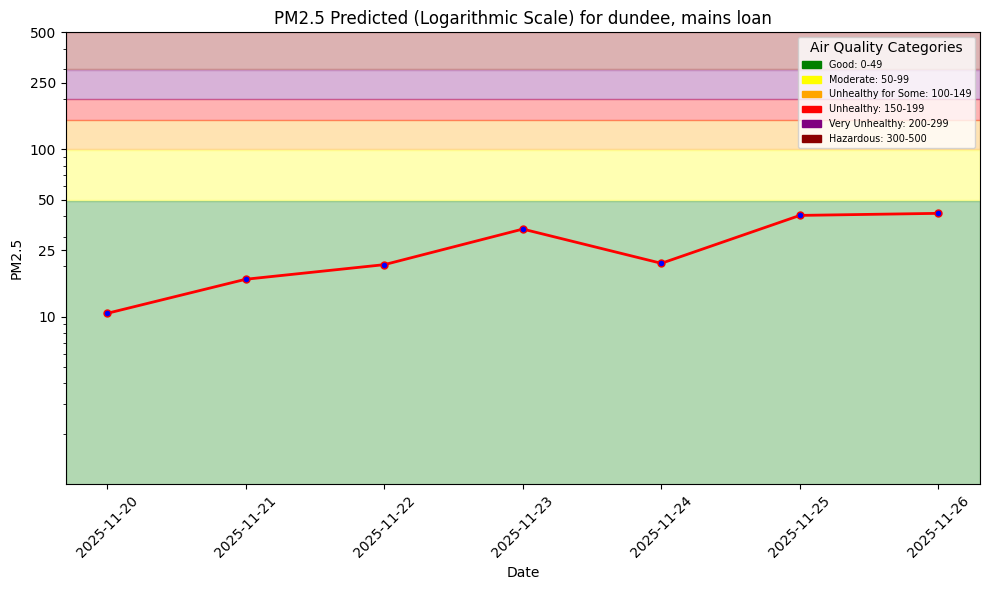

Uploading Dataframe: 100.00% |██████████████████████████████████| Rows 7/7 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296538/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-18 23:41:12,243 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 23:41:18,657 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 23:42:51,306 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 23:42:51,461 INFO: Waiting for log aggregation to finish.
2025-11-18 23:43:03,514 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.43s) 
                       date  temperature_2m_mean  precipitation_sum  \
0 2025-11-20 00:00:00+00:00                  4.2                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant    city  pm25_lag1  

Uploading Dataframe: 100.00% |████████████████████████████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296538/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-18 23:43:25,490 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 23:43:28,659 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 23:45:13,980 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 23:45:14,132 INFO: Waiting for log aggregation to finish.
2025-11-18 23:45:29,425 INFO: Execution finished successfully.
                          date  temperature_2m_mean  precipitation_sum  \
2839 2025-11-09 00:00:00+00:00             8.686749           6.500000   
2840 2025-11-10 00:00:00+00:00             9.188833          11.400001   
2841 2025-11-11 00:00:00+00:00             8.113833          14.099998   
2842

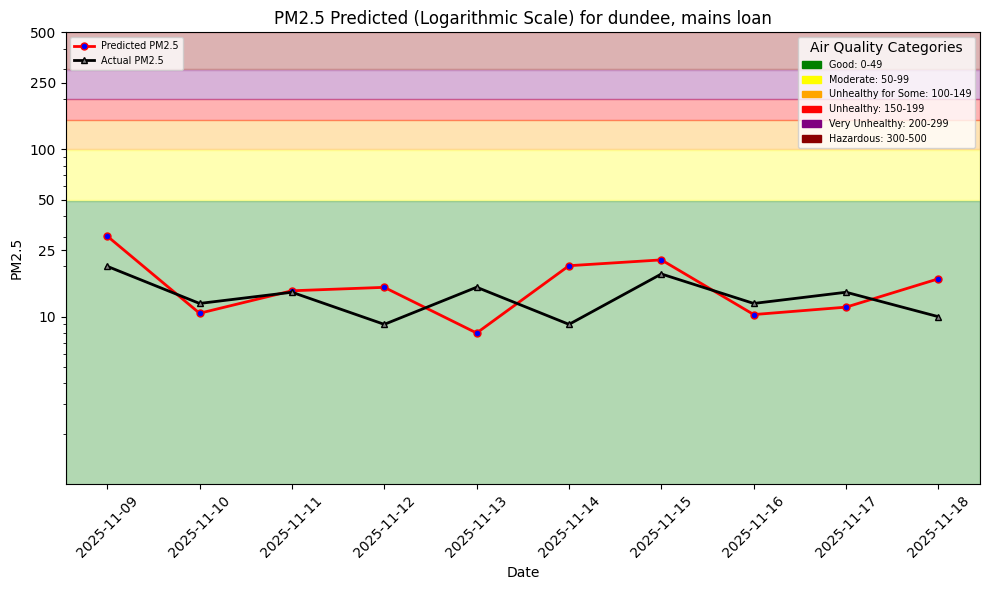

Uploading /home/viktor/mlfs-book-a-version/docs/air-quality/assets/img/pm25_forecastmains_loan.png: 0.000%|   …

Uploading /home/viktor/mlfs-book-a-version/docs/air-quality/assets/img/pm25_hindcast_1daymains_loan.png: 0.000…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1296538/settings/fb/path/Resources/airquality
{"country": "uk", "city": "dundee", "street": "broughty ferry road", "aqicn_url": "https://api.waqi.info/feed/@5970/", "latitude": 56.46, "longitude": -2.97}
2025-11-18 23:45:38,386 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/492943 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/126756 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25942 elapsed<00:00 remaining<?

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.69s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.30s) 
date                 2025-11-17 00:00:00+00:00
pm25                                      16.0
country                                     uk
city                                    dundee
street                     broughty ferry road
url          https://api.waqi.info/feed/@5970/
pm25_lag1                                 14.0
pm25_lag2                                 19.0
pm25_lag3                                 10.0
Name: 14229, dtype: object
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.73s) 
                       date  temperature_2m_mean  precipitation_sum  \
0 2025-11-20 00:00:00+00:00                 4.20                0.0   
1 2025-11-21 00:00:00+00:00                 1.35                0.0   
2 2025-11-22 00:00:00+00:00                 7.05                0.0   
3 2025-1

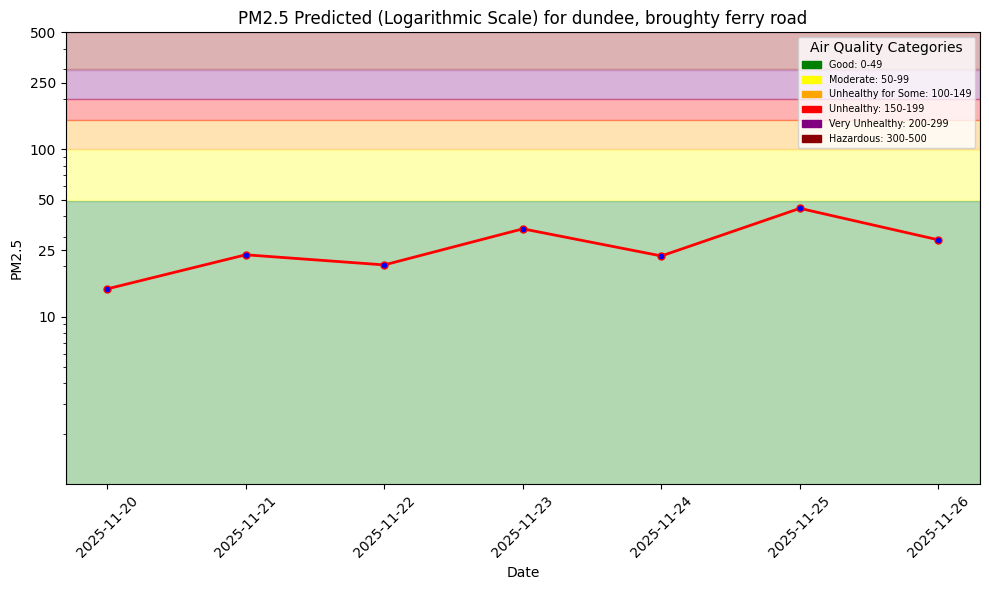

Uploading Dataframe: 100.00% |██████████████████████████████████| Rows 7/7 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296538/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-18 23:46:13,949 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 23:46:17,141 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 23:47:49,758 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 23:47:49,905 INFO: Waiting for log aggregation to finish.
2025-11-18 23:48:05,136 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.29s) 
                       date  temperature_2m_mean  precipitation_sum  \
0 2025-11-20 00:00:00+00:00                  4.2                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant    city  pm25_lag

Uploading Dataframe: 100.00% |████████████████████████████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296538/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-18 23:48:27,157 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 23:48:30,352 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 23:50:05,802 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 23:50:05,949 INFO: Waiting for log aggregation to finish.
2025-11-18 23:50:14,520 INFO: Execution finished successfully.
                          date  temperature_2m_mean  precipitation_sum  \
2696 2025-11-08 00:00:00+00:00            11.045085           2.400000   
2697 2025-11-09 00:00:00+00:00             8.686749           6.500000   
2698 2025-11-10 00:00:00+00:00             9.188833          11.400001   
2699

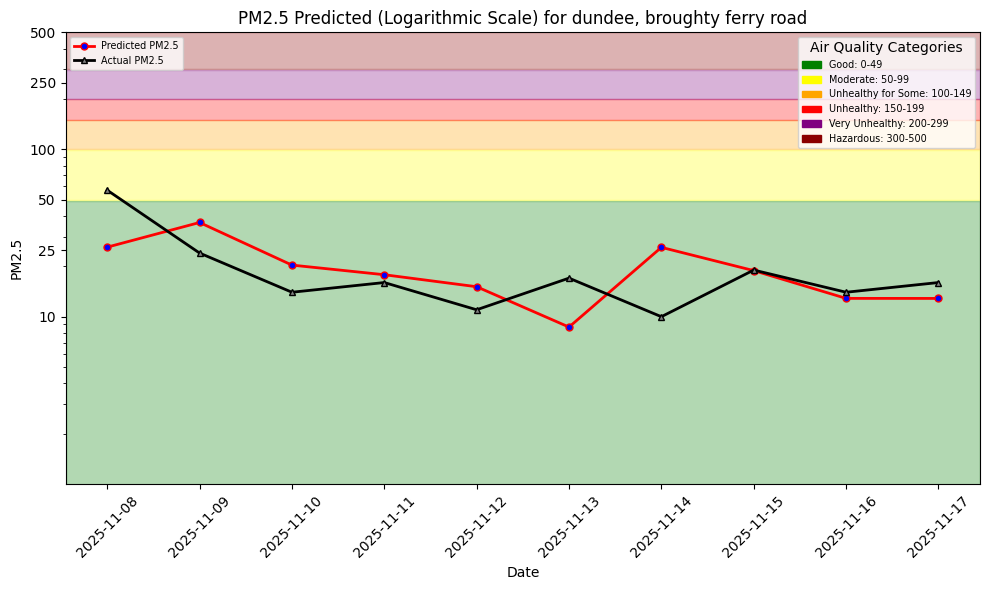

Uploading /home/viktor/mlfs-book-a-version/docs/air-quality/assets/img/pm25_forecastbroughty_ferry_road.png: 0…

Uploading /home/viktor/mlfs-book-a-version/docs/air-quality/assets/img/pm25_hindcast_1daybroughty_ferry_road.p…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1296538/settings/fb/path/Resources/airquality
Finnished.


In [25]:
for sensor in SENSORS:
    street = sensor["street"]
    #Load the location!
    street_safe = street.replace(" ", "_").upper()
    secret_name = f"SENSOR_LOCATION_JSON_{street_safe}"
    location_str = secrets.get_secret(secret_name).value #location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
    location = json.loads(location_str)
    country=location['country']
    city=location['city']
    street=location['street']
    aqicn_url=location['aqicn_url']
    latitude=location['latitude']
    longitude=location['longitude']

    print(location_str)
    
    inference(country, city, street, aqicn_url)

print("Finnished.")